# Time Series Cross-Validation with Grouped Workflows

This notebook demonstrates time series cross-validation for grouped panel data using the refinery margins dataset.

**Pattern**: Same as `forecasting_recipes_grouped.ipynb` but with time series CV evaluation

## Contents:
1. Data loading and panel structure
2. Time series CV strategies (rolling, expanding)
3. Model evaluation across CV folds
4. Fold-wise performance analysis
5. Aggregating CV metrics
6. Comparing models across folds

In [1]:
!pip install -e .

Obtaining file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/_md
ERROR: file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/_md does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# py-tidymodels imports
from py_workflows import workflow
from py_parsnip import linear_reg, rand_forest, boost_tree
from py_rsample import initial_split, training, testing, time_series_cv
from py_yardstick import metric_set, rmse, mae, r_squared
from py_tune import fit_resamples

# Recipe imports
from py_recipes import recipe
from py_recipes.selectors import all_numeric_predictors
from py_visualize import plot_forecast

# Set random seed
np.random.seed(42)

print("✓ Imports complete")

✓ Imports complete


## 1. Data Loading

Load refinery margins panel data.

In [3]:
# Import data
raw_data = pd.read_csv('__data/refinery_margins.csv')
df = raw_data.copy()
df['date'] = pd.to_datetime(df['date'])

print(f"Data shape: {df.shape}")
print(f"Countries: {sorted(df['country'].unique())}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
display(df.head())

Data shape: (1920, 20)
Countries: ['Algeria', 'Denmark', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Romania', 'Russian Federation', 'Turkey', 'United Kingdom']
Date range: 2006-01-01 00:00:00 to 2021-12-01 00:00:00


,date,country,refinery_kbd,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,es_sider_cracking_med,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc
0,2006-01-01,Algeria,450.0000,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
1,2006-01-01,Denmark,172.9948,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
2,2006-01-01,Germany,2270.5419,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
3,2006-01-01,Italy,1859.7058,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
4,2006-01-01,Netherlands,907.5555,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57


In [4]:
# Train/test split
split = initial_split(df, prop=0.75, seed=123)
train_data = training(split)
test_data = testing(split)

print(f"Training: {train_data.shape[0]} rows")
print(f"Test: {test_data.shape[0]} rows")

Training: 1440 rows
Test: 480 rows


## 2. Time Series CV Setup

Create rolling window CV folds (using Germany data for demonstration).

In [5]:
# Extract Germany data for CV demonstration
train_germany = train_data[train_data['country'] == 'Germany'].copy()

# Create rolling window CV
cv_folds = time_series_cv(
    train_germany,
    date_column='date',
    initial='18 months',
    assess='3 months',
    skip='2 months',
    cumulative=False
)

print(f"Created {len(cv_folds.splits)} CV folds")

Created 42 CV folds


## 3. Model Evaluation with fit_resamples

Evaluate models across CV folds.

In [6]:
# Formula
FORMULA_STR = "refinery_kbd ~ ."
metrics = metric_set(rmse, mae, r_squared)

# Linear Regression
wf_lr = workflow().add_formula(FORMULA_STR).add_model(linear_reg().set_engine("sklearn"))
results_lr = fit_resamples(wf_lr, resamples=cv_folds, metrics=metrics)

print("✓ Linear Regression CV complete")
display(results_lr.metrics)

✓ Linear Regression CV complete


,metric,value,.resample,.config
0,rmse,6252.358008,Fold01,config_001
1,mae,6223.659841,Fold01,config_001
2,r_squared,-477889.230791,Fold01,config_001
3,rmse,1569.158508,Fold02,config_001
4,mae,1544.958183,Fold02,config_001
...,...,...,...,...
121,mae,166.392036,Fold41,config_001
122,r_squared,-7.017741,Fold41,config_001
123,rmse,56.582738,Fold42,config_001
124,mae,54.722931,Fold42,config_001


In [7]:
# Random Forest
wf_rf = workflow().add_formula(FORMULA_STR).add_model(rand_forest(trees=100, mtry=3).set_mode("regression"))
results_rf = fit_resamples(wf_rf, resamples=cv_folds, metrics=metrics)

print("✓ Random Forest CV complete")

✓ Random Forest CV complete


In [8]:
# XGBoost
wf_xgb = workflow().add_formula(FORMULA_STR).add_model(boost_tree(trees=100).set_engine("xgboost"))
results_xgb = fit_resamples(wf_xgb, resamples=cv_folds, metrics=metrics)

print("✓ XGBoost CV complete")

✓ XGBoost CV complete


## 4. Aggregate CV Metrics

Summarize performance across folds.

In [9]:
# Aggregate metrics
summary_data = []

for model_name, results in [('Linear Reg', results_lr), ('Random Forest', results_rf), ('XGBoost', results_xgb)]:
    for metric_name in ['rmse', 'mae', 'r_squared']:
        values = results.metrics[results.metrics['metric'] == metric_name]['value'].values
        summary_data.append({
            'Model': model_name,
            'Metric': metric_name,
            'Mean': values.mean(),
            'Std': values.std()
        })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

,Model,Metric,Mean,Std
0,Linear Reg,rmse,550.001712,978.705743
1,Linear Reg,mae,518.284868,970.354434
2,Linear Reg,r_squared,-14580.003771,74277.579390
3,Random Forest,rmse,81.713608,53.107786
4,Random Forest,mae,73.940505,50.721185
5,Random Forest,r_squared,-10.917419,20.721533
6,XGBoost,rmse,101.542152,54.440933
7,XGBoost,mae,93.906962,53.179830
8,XGBoost,r_squared,-73.996516,296.511965


## 5. Visualize CV Results

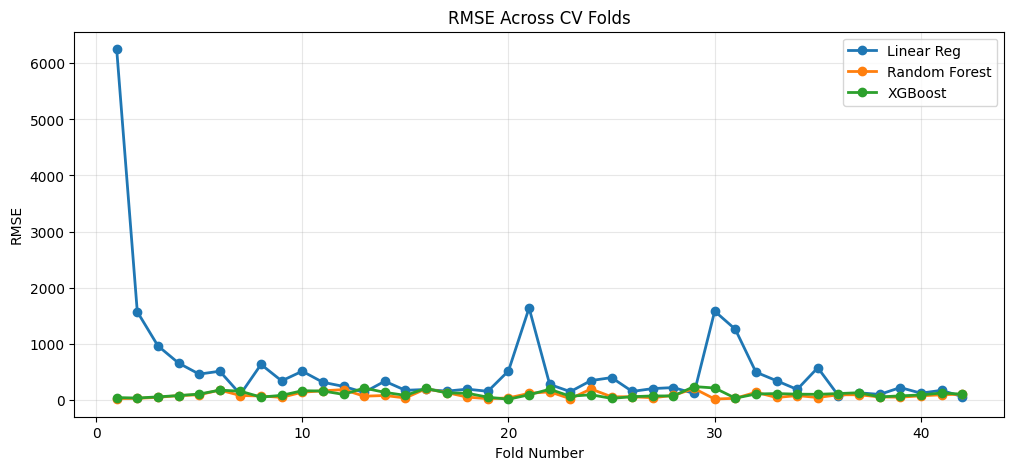

In [10]:
# Plot RMSE across folds
fig, ax = plt.subplots(figsize=(12, 5))

for model_name, results in [('Linear Reg', results_lr), ('Random Forest', results_rf), ('XGBoost', results_xgb)]:
    rmse_values = results.metrics[results.metrics['metric'] == 'rmse']['value'].values
    ax.plot(range(1, len(rmse_values) + 1), rmse_values, marker='o', label=model_name, linewidth=2)

ax.set_xlabel('Fold Number')
ax.set_ylabel('RMSE')
ax.set_title('RMSE Across CV Folds')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## 6. Final Model Training

Train best model on all groups and evaluate.

In [11]:
# Select best model (lowest RMSE)
rmse_summary = summary_df[summary_df['Metric'] == 'rmse']
best_model = rmse_summary.loc[rmse_summary['Mean'].idxmin(), 'Model']

print(f"Best model: {best_model}")

# Train on all groups
if best_model == 'Linear Reg':
    best_wf = wf_lr
elif best_model == 'Random Forest':
    best_wf = wf_rf
else:
    best_wf = wf_xgb

fit_best = best_wf.fit_nested(train_data, group_col='country')
fit_best = fit_best.evaluate(test_data)

outputs, coefs, stats = fit_best.extract_outputs()
print("\n✓ Final model fitted to all groups")
display(stats[stats['split'] == 'test'])

# Plot forecast
fig = plot_forecast(fit_best, title=f"{best_model} - All Groups")
fig.show()

Best model: Random Forest


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_workflows/workflow.py:576: UserWarning: per_group_prep=True requires a recipe preprocessor. Workflow uses formula-only preprocessing. Falling back to per_group_prep=False.
  warnings.warn(



✓ Final model fitted to all groups


,country,split,metric,value,model,model_group_name,group
7,Algeria,test,rmse,144.400275,rand_forest,,Algeria
8,Algeria,test,mae,86.300833,rand_forest,,Algeria
9,Algeria,test,mape,10.250581,rand_forest,,Algeria
10,Algeria,test,smape,22.581601,rand_forest,,Algeria
11,Algeria,test,r_squared,0.022877,rand_forest,,Algeria
...,...,...,...,...,...,...,...
270,United Kingdom,test,mape,31.566183,rand_forest,,United Kingdom
271,United Kingdom,test,smape,26.413096,rand_forest,,United Kingdom
272,United Kingdom,test,r_squared,-5.281292,rand_forest,,United Kingdom
273,United Kingdom,test,mda,51.06383,rand_forest,,United Kingdom


## Summary

This notebook demonstrated:

1. **Time series CV setup** - Rolling window strategy
2. **fit_resamples()** - Evaluate models across CV folds
3. **Metric aggregation** - Mean and std across folds
4. **Model comparison** - Identify best performing model
5. **Final training** - Apply best model to all groups

**Key Findings:**
- CV provides robust performance estimates
- Low std indicates stable model performance
- Best model selected based on CV results

**Next Steps:**
- See `forecasting_tuning_workflows.ipynb` for hyperparameter tuning with CV
- See `forecasting_workflowsets_grouped.ipynb` for multi-model comparison